In [ ]:
# Standardize columns, test sklearn linearregression, sgd

In [60]:
import torch 
from models import LM
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [61]:
data = pd.read_csv("../../Data/csvs/full_data.csv")
data.head()

,lat,lon,pvo,irradiance,elevation,cvh,sd,msl,tcc,t2m,u100,v100,sf,tp
0,25.01,-80.86,4.806000,229.686570,-0.100000,0.0,0.0,101686.95,0.475711,298.03910,-2.719398,-0.084908,0.0,0.002281
1,25.01,-80.38,4.742417,227.823326,-5.324144,0.0,0.0,101687.93,0.483685,298.14987,-2.745007,-0.021706,0.0,0.002306
2,25.01,-80.46,4.754083,225.595268,-5.826279,0.0,0.0,101687.93,0.483685,298.14987,-2.745007,-0.021706,0.0,0.002306
3,25.01,-80.50,4.768333,229.447935,-1.299589,0.0,0.0,101687.93,0.483685,298.14987,-2.745007,-0.021706,0.0,0.002306
4,25.01,-80.58,4.764667,226.067122,-0.945366,0.0,0.0,101687.93,0.483685,298.14987,-2.745007,-0.021706,0.0,0.002306


In [62]:
from sklearn.model_selection import train_test_split
data  = data.drop('irradiance', axis = 1)
y = data['pvo']
X = data.drop('pvo', axis = 1)
for col in X.columns:
    X[col] = (X[col] - X[col].mean())/X[col].std()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [63]:
X_train = torch.tensor(X_train.values, dtype = torch.float32)
y_train = torch.tensor(y_train.values, dtype = torch.float32)
X_test = torch.tensor(X_test.values, dtype = torch.float32)
y_test = torch.tensor(y_test.values, dtype = torch.float32)

# SGD Optimizer Trained Model

In [64]:
model = LM()
model.train(X_train, y_train, X_test, y_test, epochs = 20)

/phys/linux/64/anaconda/python3/current/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/phys/linux/64/anaconda/python3/current/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 Loss: 0.26352936029434204
Epoch: 2 Loss: 0.2931915521621704
Epoch: 3 Loss: 0.16225957870483398
Epoch: 4 Loss: 0.331887423992157
Epoch: 5 Loss: 0.23527248203754425
Epoch: 6 Loss: 0.1850137859582901
Epoch: 7 Loss: 0.3567635416984558
Epoch: 8 Loss: 0.25470805168151855
Epoch: 9 Loss: 0.1882360875606537
Epoch: 10 Loss: 0.30272555351257324
Epoch: 11 Loss: 0.2520357668399811
Epoch: 12 Loss: 0.21269875764846802
Epoch: 13 Loss: 0.2683766484260559
Epoch: 14 Loss: 0.24792534112930298
Epoch: 15 Loss: 0.2904507517814636
Epoch: 16 Loss: 0.2428194135427475
Epoch: 17 Loss: 0.31360527873039246
Epoch: 18 Loss: 0.24869957566261292
Epoch: 19 Loss: 0.24593102931976318
Epoch: 20 Loss: 0.2749144434928894


Text(0, 0.5, 'MSE Loss')

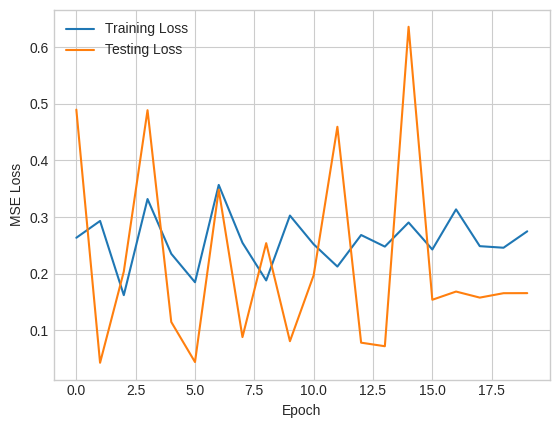

In [65]:
tr_loss, te_loss = model.loss()
plt.plot(tr_loss, label = 'Training Loss')
plt.plot(te_loss, label = 'Testing Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')

In [71]:
(model.predict(X_test.to(device))[:,0] - y_test.to(device)).mean()

tensor(0.0617, device='cuda:0', grad_fn=<MeanBackward0>)

In [72]:
mse = ((model.predict(X_test.to(device))[:,0] - y_test.to(device))**2).mean()
mse

tensor(0.2392, device='cuda:0', grad_fn=<MeanBackward0>)

# Adam Optimizer Trained Model

In [75]:
mod = LM()
mod.loadModel('LM.pt.tar')
loss = np.loadtxt('loss.txt')

In [76]:
tr_loss = loss[:,0]
te_loss = loss[:,1]

Text(0, 0.5, 'MSE Loss')

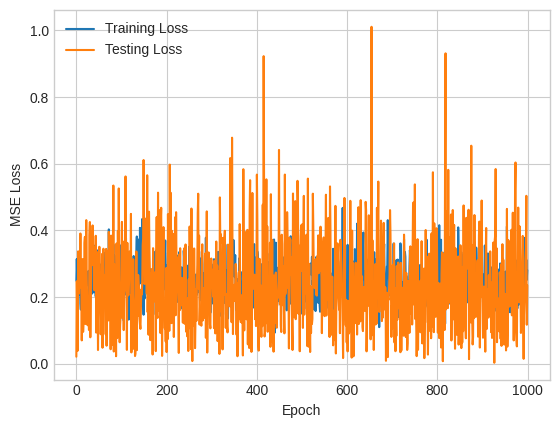

In [77]:
plt.plot(tr_loss, label = 'Training Loss')
plt.plot(te_loss, label = 'Testing Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')

In [78]:
device =  "cuda" if torch.cuda.is_available() else "cpu"

In [79]:
X_train = X_train.to(device)
y_train = y_train.to(device)

In [80]:
mse = ((mod.predict(X_train)[:,0] - y_train)**2).mean()

In [81]:
mse

tensor(0.2332, device='cuda:0', grad_fn=<MeanBackward0>)

In [82]:
blank = LM()
blank.predict(X_train)

tensor([[0.7323],
        [0.7296],
        [0.7312],
        ...,
        [0.7374],
        [0.6791],
        [0.6791]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [83]:
bmse = ((blank.predict(X_train)[:,0] - y_train)**2).sum().item()

# Logistic Regression

In [84]:
from sklearn.linear_model import LinearRegression

In [85]:
LR = LinearRegression()
LR.fit(X_train.cpu(), y_train.cpu())

LinearRegression()

In [86]:
preds = LR.predict(X_test)

In [87]:
LRmse = ((preds - y_test.cpu().numpy())**2).mean()

In [88]:
LRmse

0.013634425